In [1]:
#import dependencies
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy import stats
from scipy.stats import linregress
import gmaps
import os
import json
import pprint as pprint

In [2]:
inflow_df = pd.read_csv('input_data/countyinflow1718.csv')
outflow_df = pd.read_csv('input_data/countyoutflow1718.csv')

#pull out pertinant rows in each df
inflow_df = inflow_df[inflow_df['y1_countyname'].str.contains('County Non-migrants') | inflow_df['y1_countyname'].str.contains('County Total Migration-US and Foreign')]
outflow_df = outflow_df[outflow_df['y2_countyname'].str.contains('County Non-migrants') | outflow_df['y2_countyname'].str.contains('County Total Migration-US and Foreign')]

#rename columns
inflow_df = inflow_df.rename(columns = {"y1_countyname":"inflow_county","y1_state":"inflow_state","n1":"inflow_n1","n2":"inflow_n2","agi_y":"inflow_agi"})
outflow_df = outflow_df.rename(columns = {"y2_countyname":"outflow_county","y2_state":"outflow_state","n1":"outflow_n1","n2":"outflow_n2","agi_x":"outflow_agi"})

#merge df
county_in_out_df = pd.merge(outflow_df,inflow_df,left_on=["outflow_state","outflow_county"],right_on=["inflow_state","inflow_county"])

#remove unneccessary columns
county_in_out_df = county_in_out_df.drop(columns=['y1_statefips_x', 'y1_countyfips_x', 'y2_statefips_x', 'y2_countyfips_x', 'y2_statefips_y', 'y2_countyfips_y', 'y1_statefips_y', 'y1_countyfips_y'])

In [3]:
#separate data based on description and merge
non_migrants = county_in_out_df[county_in_out_df['outflow_county'].str.contains("Non-migrants")]
non_migrants = non_migrants.reset_index()

us_foreign = county_in_out_df[county_in_out_df['outflow_county'].str.contains('US and Foreign')]
us_foreign = us_foreign.reset_index()

# Merge two Dataframes on index of both the dataframes
final = non_migrants.merge(us_foreign, left_index=True, right_index=True)

#drop unnecessary columns
final = final.drop(columns=['index_x', 'outflow_state_x', 'outflow_county_x', 'outflow_n1_x', 'outflow_n2_x', 'agi_x_x', 'index_y',
                   'outflow_state_y', 'outflow_county_y', 'inflow_state_y', 'inflow_county_y', 'inflow_n2_x', 'outflow_n2_y', 'inflow_n2_y'])
final

,inflow_state_x,inflow_county_x,inflow_n1_x,agi_y_x,outflow_n1_y,agi_x_y,inflow_n1_y,agi_y_y
0,AL,Autauga County Non-migrants,18028,1143227,1888,99955,1925,100564
1,AL,Baldwin County Non-migrants,73765,5421048,4609,238893,6818,491043
2,AL,Barbour County Non-migrants,7176,322664,445,16473,389,15215
3,AL,Bibb County Non-migrants,6054,332129,450,18686,376,15189
4,AL,Blount County Non-migrants,17300,982763,1148,51327,1211,52661
...,...,...,...,...,...,...,...,...
3001,WY,Sweetwater County Non-migrants,15417,1216231,1084,71652,834,43730
3002,WY,Teton County Non-migrants,10727,3408826,1218,109912,1188,212532
3003,WY,Uinta County Non-migrants,7077,509964,485,31788,441,22104
3004,WY,Washakie County Non-migrants,2875,193724,180,7868,162,8388


In [4]:
#strip words from description
final['inflow_county_x'] = final['inflow_county_x'].str.rstrip(' Non-migrants')

#rename columns
final = final.rename(columns={'inflow_state_x': 'State', 'inflow_county_x': 'County', 'inflow_n1_x': 'Returns Total', 
                             'agi_y_x': 'Total AGI', 'outflow_n1_y': 'Outflow', 'agi_x_y': 'Outflow AGI',
                             'inflow_n1_y': 'Inflow', 'agi_y_y': 'Inflow AGI'})

In [5]:
#add net flow column and compute values
final['Net Inflow(Outflow)'] = (final['Inflow'] - final['Outflow']).astype(int)

#add percentage column and compute values
final['Flow(%)'] = (final['Net Inflow(Outflow)'] / final['Returns Total']).astype(float)

#format percentage column
final['Flow(%)'] = (final['Flow(%)'] * 100).round(3)

#sort by percentage column values
final = final.sort_values(by=['Flow(%)'], ascending=False)


In [6]:
#read in unemployment data
unemployment = pd.read_csv('input_data/unemployment.csv')

#drop unnecessary columns
unemployment = unemployment.drop(columns=['Year', 'Force', 'Employed', 'Unemployed'])
#rename columns
unemployment = unemployment.rename(columns={'(%)': 'Unemployment Rate(%)'})
#reorder columns
unemployment = unemployment[['State', 'County', 'Unemployment Rate(%)']]

In [7]:
final = final.merge(unemployment, on=['State', 'County'])
final

,State,County,Returns Total,Total AGI,Outflow,Outflow AGI,Inflow,Inflow AGI,Net Inflow(Outflow),Flow(%),Unemployment Rate(%)
0,NV,Eureka County,556,38167,26,2961,78,4974,52,9.353,2.7
1,NE,Hooker County,279,10670,-1,-1,21,874,22,7.885,3.7
2,ND,McKenzie County,3461,464151,575,46125,837,52025,262,7.570,1.7
3,CO,Mineral County,324,21265,-1,-1,22,1256,23,7.099,2.6
4,ND,Williams County,12437,1217462,1644,112302,2504,137024,860,6.915,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2995,TX,Roberts County,275,17228,29,2415,-1,-1,-30,-10.909,3.0
2996,MT,Treasure County,274,14096,31,1657,-1,-1,-32,-11.679,3.0
2997,NE,Logan County,253,11987,29,1271,-1,-1,-30,-11.858,2.8
2998,TX,Kent County,252,16917,30,1474,-1,-1,-31,-12.302,2.4


In [8]:
#Rent data

#read in rent data
rent_data = pd.read_csv('input_data/FY2018_50_County_rev.csv')

#delete unnecessary columns
rent_data = rent_data.drop(columns = ['fips2010', 'state', 'cbsasub18', 'areaname18', 'county', 'cousub', 'name', 'pop2010', 'hu2010', 'rent50_0', 'rent50_3', 'rent50_4'])

#rename columns
rent_data = rent_data.rename(columns = {"rent50_1":"1 Bed Average","rent50_2":"2 Bed Average","cntyname":"County","state_alpha":"State"})

#reorder data
rent_data = rent_data[['State', 'County', '1 Bed Average', '2 Bed Average']]
rent_data

,State,County,1 Bed Average,2 Bed Average
0,AL,Autauga County,742,890
1,AL,Baldwin County,809,929
2,AL,Barbour County,531,706
3,AL,Bibb County,832,955
4,AL,Blount County,832,955
...,...,...,...,...
4765,PR,Yabucoa Municipio,478,577
4766,PR,Yauco Municipio,340,390
4767,VI,St. Croix,833,1017
4768,VI,St. John,1284,1596


In [9]:
#merge rent data to final
final = final.merge(rent_data, on=['State', 'County'])

In [10]:
#read in average tmp data
temp_data = pd.read_csv('input_data/final_cnty_avg_temps.csv')
temp_data.head()
#drop unnecessary columns
temp_data = temp_data.drop(columns=['STATE AVERAGE TEMPERATURE (F)'])
#reorder
temp_data = temp_data[['STATE', 'COUNTY NAME', 'COUNTY AVERAGE TEMPERATURE (F)']]
#rename
temp_data = temp_data.rename(columns={'STATE': 'State', 'COUNTY NAME': 'County', 'COUNTY AVERAGE TEMPERATURE (F)': 'Average Temp (F)'})
temp_data.head()

,State,County,Average Temp (F)
0,AL,Autauga County,62.8
1,AL,Baldwin County,66.7
2,AL,Barbour County,63.8
3,AL,Bibb County,62.6
4,AL,Blount County,60.8


In [11]:
#merge into final data
final = final.merge(temp_data, on=['State', 'County'])
final

,State,County,Returns Total,Total AGI,Outflow,Outflow AGI,Inflow,Inflow AGI,Net Inflow(Outflow),Flow(%),Unemployment Rate(%),1 Bed Average,2 Bed Average,Average Temp (F)
0,NV,Eureka County,556,38167,26,2961,78,4974,52,9.353,2.7,709,943,47.2
1,NE,Hooker County,279,10670,-1,-1,21,874,22,7.885,3.7,521,693,47.7
2,ND,McKenzie County,3461,464151,575,46125,837,52025,262,7.570,1.7,700,931,43.1
3,CO,Mineral County,324,21265,-1,-1,22,1256,23,7.099,2.6,760,980,37.6
4,ND,Williams County,12437,1217462,1644,112302,2504,137024,860,6.915,2.0,733,940,40.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535,TX,Roberts County,275,17228,29,2415,-1,-1,-30,-10.909,3.0,629,792,57.5
4536,MT,Treasure County,274,14096,31,1657,-1,-1,-32,-11.679,3.0,670,849,47.1
4537,NE,Logan County,253,11987,29,1271,-1,-1,-30,-11.858,2.8,491,653,48.6
4538,TX,Kent County,252,16917,30,1474,-1,-1,-31,-12.302,2.4,553,697,61.7


In [16]:
final.to_csv('output_data/final.csv', index=False)

In [12]:
#create a random sample of 10%
sample_300 = final.sample(n=300)
sample_300

,State,County,Returns Total,Total AGI,Outflow,Outflow AGI,Inflow,Inflow AGI,Net Inflow(Outflow),Flow(%),Unemployment Rate(%),1 Bed Average,2 Bed Average,Average Temp (F)
137,CO,Douglas County,115898,16401047,12989,1438525,16067,1541931,3078,2.656,2.9,1226,1543,50.2
472,ME,Piscataquis County,5832,274080,343,14073,425,17748,82,1.406,4.2,617,708,38.8
2149,KY,Daviess County,35825,2241060,1636,79669,1666,76280,30,0.084,4.0,562,745,57.2
2508,ME,Penobscot County,54471,3239598,3068,148356,3002,139529,-66,-0.121,3.8,668,870,41.7
3860,MA,Middlesex County,624151,86407105,48934,4974179,43495,3823209,-5439,-0.871,2.7,1546,1894,47.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,TX,Real County,1184,58578,89,3913,113,5603,24,2.027,5.0,630,723,65.4
3659,KY,Lyon County,2508,149442,245,10106,227,14633,-18,-0.718,5.1,471,620,57.6
619,ME,York County,84439,5840835,5206,290171,6274,400274,1068,1.265,3.0,1108,1417,45.6
454,NH,Carroll County,20715,1732343,1397,84791,1689,172857,292,1.410,2.5,882,1106,42.1


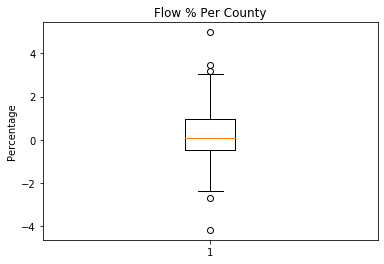

In [13]:
#runbow/whisker plot on sample data
fig1, ax1 = plt.subplots()
ax1.set_title('Flow % Per County')
ax1.set_ylabel('Percentage')
ax1.boxplot(sample_300['Flow(%)'])
plt.show()

In [14]:
quartiles = sample_300['Flow(%)'].quantile([.25, .5, .75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq - lowerq

print(f'The lower quartiles is: {lowerq}')
print(f'The upper quartiles is: {upperq}')
print(f'The interquartile range is: {iqr}')
print(f'The median is: {quartiles[0.5]}')

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f'Values below {lower_bound} may be outliers.')
print(f'Values above {upper_bound} may be outliers.')

The lower quartiles is: -0.47324999999999995
The upper quartiles is: 0.952
The interquartile range is: 1.42525
The median is: 0.08549999999999999
Values below -2.6111249999999995 may be outliers.
Values above 3.0898749999999997 may be outliers.


In [15]:
sample_300.to_csv('output_data/sample_300.csv', index=False)